# Running alchemical free energy calculations

`ASAP-Alchemy` provides a set of automated workflows which when combined create and end-to-end pipeline enabling the routine running of state-of-the-art alchemical free energy calculations at (Alchemi)scale! In this tutorial we cover configuring and executing each of the workflows via the python API, but note `ASAP-Alchemy` also provides a CLI which can be used to execute any of the workflows and accepts custom configuration files providing the same amount of flexibility as the API but with easier execution! We also have tried and tested defaults in all of our workflows which are used in production so feel free to skip configuring each workflow unless you really need the extra flexibility.

## General design
Each of the workflows in `ASAP-Alchemy` are designed following the same factory pattern which allows them to have a similar API which should make them all fell familair. Each workflow then begins as a resuable configuration object which defines the runtime options of that pipeline which can then be applied to sets of molecules.

# ASAP-Alchemy Prep
The first stage in the workflow is called `prep` and has two main jobs:

- **State Enumeration**: Enumerate the tautomers, protomers and stereoisomers of the input ligands

- **Constrained Pose Generation**: Generate initial poses for the lignads while constraining the ligand to match the crystal structure reference conformation.

We will now walk through the process building a standard `AlchemyPrepWorkflow` and assinging the required componet parts:

In [1]:
from asapdiscovery.alchemy.schema.prep_workflow import AlchemyPrepWorkflow
from asapdiscovery.data.operators.state_expanders.protomer_expander import EpikExpander
from asapdiscovery.data.operators.state_expanders.stereo_expander import StereoExpander
from asapdiscovery.docking.schema.pose_generation import (
    OpenEyeConstrainedPoseGenerator,
    RDKitConstrainedPoseGenerator,
)

prep_workflow = AlchemyPrepWorkflow()

## Stereo expansion

Molecules with unknown stereo centers should be fully expanded before generating an initial pose to ensure we know the eact identity of the molecule we are making the prediction for, this also allows us to predict free energy differeces between steroisomers which might offer more insight to the med chem team! 

So lets add our `openeye` stereo expander module to the workflow and set it to only expand any undefined stereo centers in the input molecules:

In [2]:
stereo_expander = StereoExpander(stereo_expand_defined=False)
prep_workflow.stereo_expander = stereo_expander

## Charge and Tautomeric expansion

Druglike molecules often have multipule accessible protonation and tautomeric states at experimetnal pH which can contribute to binding and considering a single state in alchemical free energy calculations can introduce significiant error. One option is to use tools like openeye to try and predict the most reasonable form of a molecule at the experimental pH in question, another is to enumerate all possible forms and and use a state pentalty correction scheme based on the predicted pKa of each state. You can read more about this at <https://pubs.acs.org/doi/10.1021/acs.jctc.8b00826>.

`ASAP-Alchemy` prodvies both of these enumeration options (`EpikExpander`, `ProtomerExpander`, `TautomerExpander`) however they are under active development and so by default we skip this stage by setting it to `None`:

In [3]:
prep_workflow.charge_expander = None

## Pose Generator

We now need to select a backend which will be used to generate the initial poses for our molecules. We have two options available `OpenEyeConstrainedPoseGenerator` and the `RDKitConstrainedPoseGenerator`. Both implimentations use the same general workflow to generate the poses, that is find the MCS overlap between the target ligand and some refernce ligand (normally extracted from a crystal refernce structure) and constrain the overlaping atoms of the target ligand to match the refernce. Then for any atoms not constrained we enumerate the rotomers of any rotable bonds using the backend toolkit and filter down to a single favourable conformer for each target ligand in the series. 

By default we use the `RDKitConstrainedPoseGenerator` as follows:

In [4]:
pose_generator = RDKitConstrainedPoseGenerator(
    max_confs = 300,  # The maximum number of conformers to try and generate
    rms_thresh = 0.2, # The RMSD between the heavy atoms which should be used to filter duplicated conformers
    mcs_timeout = 1, # The time in seconds to the MCS search for 
)
prep_workflow.pose_generator = pose_generator

## Core Smarts 

In some cases you may not want to constrain the full MCS between a target molecule and the refernce ligand, in these cases you can provide a core SMARTS pattern which will be used to define the MCS. While [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html) patterns can be created by hand we recomend using ChemDraw or <https://smarts.plus/>. By default we let the pose generator find the MCS which can be done by setting the `core_smarts` field to `None`.

In [5]:
prep_workflow.core_smarts = None

## Stereochemistry filtering

During the pose generation process some molecules end up with inconsistent stereochemistry, that is the stereochemistry we intended does not match the 3D geometry of the molecule. This often happens when our refernce ligand contains a stereocenter and the target ligand we are trying to pose has opposing stereochemsitry, in these cases a sensible pose can not be generated and often requires manual modeling of the refernce to allow opposing stereocenters to be generated. To ensure all molecules have the correct stereo chemistry we set the `strict_stereo` flag to `True`:

In [6]:
prep_workflow.strict_stereo = True

## Experimental references

In prospective predictions it is dersirable to not only predict a ranking of the molecules in the series but to predict the absolute binding affinity so that the results might be compared accross alchemical networks and against other ligands with experimental data which are not included in the network. 

In practice this is done by including experimental reference compounds in the alchemical network and then shifting the final predictions by the mean of the experimantal absolute binding afinities. `ASAP-Alchemy` allows users to provide a list of ligands with experimental data as references which we then try to generate poses for, the number of refernces to include can be controlled via the `n_references` field which by default is set to 3:

In [7]:
prep_workflow.n_references = 3

This completes the construction of the default `AlchemyPrepWorkflow`, and we can now view the settings of the workflow

In [8]:
prep_workflow

AlchemyPrepWorkflow(type='AlchemyPrepWorkflow', stereo_expander=StereoExpander(expander_type='StereoExpander', stereo_expand_defined=False), charge_expander=None, pose_generator=RDKitConstrainedPoseGenerator(type='RDKitConstrainedPoseGenerator', clash_cutoff=2.0, selector=<PoseSelectionMethod.Chemgauss3: 'Chemgauss3'>, backup_score=<PoseEnergyMethod.Sage: 'Sage'>, max_confs=300, rms_thresh=0.2, mcs_timeout=1), core_smarts=None, strict_stereo=True, n_references=3)

## Saving and Loading

Once configured workflows can be saved and loaded to `JSON` meaning that a workflow can be reused multipule times throughout a project to ensure that a consistent pipeline is applied to an entire series of alchemical free energy calculations in a given project.

In [9]:
prep_workflow.to_file(filename="My-prep-workflow.json")
prep_workflow_2 = AlchemyPrepWorkflow.from_file("My-prep-workflow.json")

## Running Alchemy prep

We are now ready to run our configured prep workflow and create an alchemy dataset which can be used in the next sections of the guide. Lets inspect the function to create the dataset and generate the missing parts:

In [10]:
prep_workflow.create_alchemy_dataset?

Signature:
prep_workflow.create_alchemy_dataset(
    dataset_name: str,
    ligands: list[asapdiscovery.data.schema.ligand.Ligand],
    reference_complex: asapdiscovery.data.schema.complex.PreppedComplex,
    processors: int = 1,
    reference_ligands: Optional[list[asapdiscovery.data.schema.ligand.Ligand]] = None,
) -> asapdiscovery.alchemy.schema.prep_workflow.AlchemyDataSet
Docstring:
Run the set of input ligands through the state enumeration and pose generation workflow to create a set of posed
ligands ready for ASAP-Alchemy.

Notes:
    Ligands with experimental data can be supplied via `reference_ligands`, poses will be generated
    until `self.n_references` have been successfully added. The ligands will be sorted by their MCS overlap with
    the crystal reference ligand to ensure a pose can be generated.

Args:
    dataset_name: The name which should be given to this dataset.
    ligands: The list of input ligands which should be run through the workflow.
    reference_complex

First grab a reference complex, in this example we will use a real ASAP enabled target [SARS-CoV-2 NSP3 macrodomain](https://asapdiscovery.org/outputs/molecules/#ASAP-SARS-COV-2-NSP3-MAC1) and download a prepared complex from the asapdiscovery test suite which includes a prepared receptor and ligand.

In [11]:
from asapdiscovery.data.testing.test_resources import fetch_test_file
from asapdiscovery.data.schema.complex import PreppedComplex

mac1_complex = PreppedComplex.parse_file(fetch_test_file("constrained_conformer/complex.json"))
mac1_complex


PreppedComplex(target=PreppedTarget(target_name='SARS2_Mac1A_A1496-ASAP-0008674-001', ids=None, data_format=<DataStorageType.b64oedu: 'b64oedu'>, target_hash='22bf5e21b05a8a454b5b64c52bcd95db83088d72636ee37cf37f166d71708331'), ligand=Ligand(compound_name='SARS2_Mac1A_A1496-ASAP-0008674-001_ligand', ids=None, provenance=LigandProvenance(isomeric_smiles='CC(C)[C@@H](c1ccc2c(c1)S(=O)(=O)CCC2)Nc3c4cc[nH]c4ncn3', inchi='InChI=1S/C19H22N4O2S/c1-12(2)17(23-19-15-7-8-20-18(15)21-11-22-19)14-6-5-13-4-3-9-26(24,25)16(13)10-14/h5-8,10-12,17H,3-4,9H2,1-2H3,(H2,20,21,22,23)/t17-/m0/s1', inchi_key='WLJITGAGZLIWOY-KRWDZBQOSA-N', fixed_inchi='InChI=1/C19H22N4O2S/c1-12(2)17(23-19-15-7-8-20-18(15)21-11-22-19)14-6-5-13-4-3-9-26(24,25)16(13)10-14/h5-8,10-12,17H,3-4,9H2,1-2H3,(H2,20,21,22,23)/t17-/m0/s1/f/h20,23H', fixed_inchikey='WLJITGAGZLIWOY-ZFFWTUEDNA-N'), experimental_data=None, expansion_tag=None, tags={}, conf_tags={}, data_format=<DataStorageType.sdf: 'sdf'>))

We now need a list of target molecules for which we want to estimate the binding afinity via relative free energy calculations, in this case we have some very simple molecules made as an example:

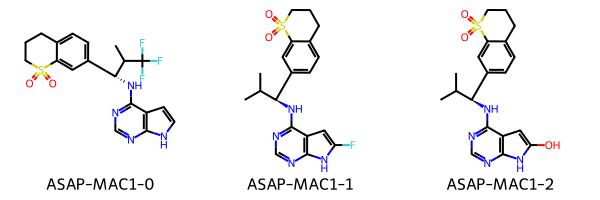

In [12]:
from asapdiscovery.data.schema.ligand import Ligand
from rdkit.Chem import Draw

molecules_smiles = [
    "CC([C@H](Nc1ncnc2[nH]ccc12)c4ccc3CCCS(=O)(=O)c3c4)C(F)(F)F",
    "CC(C)[C@H](Nc1ncnc2[nH]c(F)cc12)c4ccc3CCCS(=O)(=O)c3c4",
    "CC(C)[C@H](Nc1ncnc2[nH]c(O)cc12)c4ccc3CCCS(=O)(=O)c3c4"
]
target_ligands = [
    Ligand.from_smiles(smiles=smiles, compound_name=f"ASAP-MAC1-{i}")
    for i, smiles in enumerate(molecules_smiles)
]
Draw.MolsToGridImage(mols=[mol.to_rdkit() for mol in target_ligands], legends=[mol.compound_name for mol in target_ligands])

Finally we can optionaly pass in a set of reference ligands which can be added to the dataset to ensure the absolute predictions of the binding affinities are comparable with other experimental results. These lignads can be provided from any source so long as they are marked as experimental, we also provide tools to extract reference ligands from the CDD. Here we will make some example reference ligands:

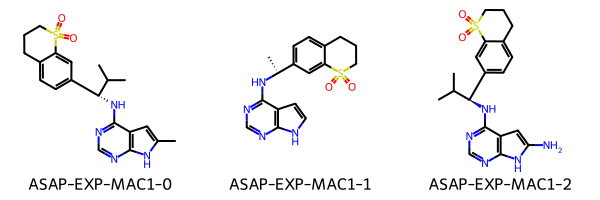

In [13]:
reference_smiles = [
    "Cc4cc3c(N[C@H](c2ccc1CCCS(=O)(=O)c1c2)C(C)C)ncnc3[nH]4",
    "C[C@H](Nc1ncnc2[nH]ccc12)c4ccc3CCCS(=O)(=O)c3c4",
    "CC(C)[C@H](Nc1ncnc2[nH]c(N)cc12)c4ccc3CCCS(=O)(=O)c3c4"
]
reference_ligands = [
    Ligand.from_smiles(smiles=smiles, compound_name=f"ASAP-EXP-MAC1-{i}", experimental=True)
    for i, smiles in enumerate(reference_smiles)
]
Draw.MolsToGridImage(mols=[mol.to_rdkit() for mol in reference_ligands], legends=[mol.compound_name for mol in reference_ligands])

We can now run the workflow and generate poses for the molecules, for this example we will reduce the number of conformers which should be generated as the modifications to the ligands are rigid and the conformer generation step is slow. In production it is recommended to use around 300 with RDKit.

In [15]:
# reduce the number of conformers just for this example
prep_workflow.pose_generator.max_confs = 10
alchemy_dataset = prep_workflow.create_alchemy_dataset(
    dataset_name="my-first-asap-dataset",
    ligands=target_ligands,
    reference_complex=mac1_complex,
    reference_ligands=reference_ligands,
)

Output()

[✓] StereoExpander successful,  number of unique ligands 4.

! WARNING the reference structure is chiral, check output structures carefully! 

Output()

[✓] Pose generation successful for 4/4.

[✓] Stereochemistry filtering complete 0 molecules removed.

Output()

[✓] Pose generation successful for 3/3 experimental ligands.

Poses successfully generated for 7 ligands.

We now have an alchemy dataset object which contains information about the workflow we have just ran including the inputs and any errors that might cause poses to not be generated for some ligands. We can also inspect provanence information about the stages run including the versions of software, for example lets look at the pose generator and the software versions used:

In [19]:
alchemy_dataset.pose_generator


RDKitConstrainedPoseGenerator(
    type='RDKitConstrainedPoseGenerator',
    clash_cutoff=2.0,
    selector=<PoseSelectionMethod.Chemgauss3: 'Chemgauss3'>,
    backup_score=<PoseEnergyMethod.Sage: 'Sage'>,
    max_confs=10,
    rms_thresh=0.2,
    mcs_timeout=1
)

In [20]:
alchemy_dataset.provenance["RDKitConstrainedPoseGenerator"]


{
    'oechem': 20230910,
    'oeff': 20230910,
    'oedocking': 20230910,
    'rdkit': '2023.09.4',
    'openff.toolkit': '0.13.2'
}

We can also inspect the posed ligands and write them to file to view them:

In [23]:
alchemy_dataset.save_posed_ligands(filename='posed_ligands.sdf')
alchemy_dataset.posed_ligands[0]


Ligand(
    compound_name='ASAP-MAC1-1',
    ids=None,
    provenance=LigandProvenance(
        isomeric_smiles='CC(C)[C@@H](c1ccc2c(c1)S(=O)(=O)CCC2)Nc3c4cc([nH]c4ncn3)F',
        inchi='InChI=1S/C19H21FN4O2S/c1-11(2)17(24-19-14-9-16(20)23-18(14)21-10-22-19)13-6-5-12-4-3-7-27(25,26)15(12)8-13/h5-6,8-11,17H,3-4,7H2,1-2H3,(H2,21,22,23,24)/t17-/m0/s1',
        inchi_key='MRECENMRQWAKSE-KRWDZBQOSA-N',
        fixed_inchi='InChI=1/C19H21FN4O2S/c1-11(2)17(24-19-14-9-16(20)23-18(14)21-10-22-19)13-6-5-12-4-3-7-27(25,26)15(12)8-13/h5-6,8-11,17H,3-4,7H2,1-2H3,(H2,21,22,23,24)/t17-/m0/s1/f/h23-24H',
        fixed_inchikey='MRECENMRQWAKSE-ITYWMMRHNA-N'
    ),
    experimental_data=None,
    expansion_tag=None,
    tags={'Chemgauss3_score': '-67.99121856689453'},
    conf_tags={'Chemgauss3_score': ['-67.99121856689453']},
    data_format=<DataStorageType.sdf: 'sdf'>
)

We might want to view the ligands in the receptor and overlay the reference structure so now we will write the reference receptor to a local pdb file and ligand to an sdf file. You can then use your any molecule viewer like pymol or use the example below which uses py3dmol:

In [45]:
import py3Dmol
alchemy_dataset.reference_complex.target.to_pdb_file('mac1-receptor.pdb')
alchemy_dataset.reference_complex.ligand.to_sdf('mac1-ref-ligand.sdf')
view = py3Dmol.view(width=400, height=300)
view.addModel(open('mac1-receptor.pdb').read(), 'pdb')
view.setStyle({'chain':['A', 'B']}, {'cartoon': {'color': 'spectrum'}})
view.addModel(alchemy_dataset.reference_complex.ligand.to_sdf_str())
for mol in alchemy_dataset.posed_ligands:
    view.addModel(mol.to_sdf_str())
view.setStyle({'model': [i + 1 for i in range(len(alchemy_dataset.posed_ligands))]}, {"stick":{}})
view.zoomTo({'model':1})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

This dataset object can then be saved to file and acts as a form of provenace for the prep workflow and should contain all of the information required to reproduce the dataset should someone want to repeate your work! 

In [46]:
alchemy_dataset.to_file("my-alchemy-dataset.json")

## Planning an Alchemical Free energy network